In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from matplotlib import pyplot as plt

In [ ]:
!git clone https://github.com/anthony-wang/CrabNet.git
%cd CrabNet
!pip install -e
!ls crabnet
!grep -rnw 'crabnet' -e 'class CrabNet'
from crabnet.kingcrab import CrabNet

Cloning into 'CrabNet'...
remote: Enumerating objects: 3190, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 3190 (delta 1), reused 1 (delta 1), pack-reused 3188 (from 3)
Receiving objects: 100% (3190/3190), 438.40 MiB | 24.51 MiB/s, done.
Resolving deltas: 100% (791/791), done.
Updating files: 100% (1283/1283), done.
/content/CrabNet

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument
kingcrab.py  model.py
crabnet/kingcrab.py:194:class CrabNet(nn.Module):


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
import pickle

# -------------------------------------------- # 데이터 가져오기
df = pd.read_excel('/content/estm.xlsx')
df1 = df[df['temperature(K)']<350]
df1 = df1[df1['temperature(K)']>100]

# ------------------------------------------- # 정규화 과정
seebeck_stats = {
    "mean": df1["seebeck_coefficient(μV/K)"].mean(),
    "std": df1["seebeck_coefficient(μV/K)"].std(ddof=0)
}
# 스케일링 적용
df1["seebeck_coefficient(μV/K)"] = (
    df1["seebeck_coefficient(μV/K)"] - seebeck_stats["mean"]
) / seebeck_stats["std"]
# 나중을 위해 저장
with open("seebeck_scaler.pkl", "wb") as f:
    pickle.dump(seebeck_stats, f)

df1['electrical_conductivity(S/m)'] = np.log10(df1['electrical_conductivity(S/m)'].clip(lower=1e-12))

pf_col = "power_factor(W/mK2)"
log_pf = np.log10(df1[pf_col].clip(lower=1e-12))   # 0 이하 방지
pf_scaler = StandardScaler()
df1[pf_col] = pf_scaler.fit_transform(log_pf.values.reshape(-1, 1))

tc_col = "thermal_conductivity(W/mK)"
tc_scaler = StandardScaler()
df1[tc_col] = tc_scaler.fit_transform(df1[tc_col].values.reshape(-1, 1))

In [ ]:
df1

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference
0,BiSb(Se0.92Br0.08)3,300.0,-0.794867,4.443513,-0.524176,0.127103,0.159985,10.1002/adfm.201806558
6,BiSb(Se0.94Br0.06)3,300.0,-0.804792,4.416923,-0.521677,0.116724,0.153568,10.1002/adfm.201806558
12,BiSb(Se0.96Br0.04)3,300.0,-0.745243,4.322219,-0.519178,-0.066511,0.120000,10.1002/adfm.201806558
18,BiSb(Se0.98Br0.02)3,300.0,-0.789905,4.340741,-0.511681,0.022075,0.120000,10.1002/adfm.201806558
24,Cu2.025Cd0.975SnSe4,300.0,0.609516,3.729327,-0.013632,-0.177322,0.018011,10.1002/adma.200900409
...,...,...,...,...,...,...,...,...
5175,(Sn0.985In0.015Te)0.9(AgCl)0.1,323.0,0.035704,5.666560,0.290220,0.751010,0.126854,https://doi.org/10.1021/acsami.0c09781
5181,(Sn0.985In0.015Te)0.85(AgCl)0.15,323.0,0.041460,5.623482,0.317984,0.726636,0.116247,https://doi.org/10.1021/acsami.0c09781
5187,Cu2SnSe3,323.0,0.194106,4.122707,0.024702,-0.349141,0.012086,https://doi.org/10.1021/acsami.0c04298
5193,Cu2Sn0.95Fe0.05Se3,323.0,0.026325,5.061852,0.175042,0.149707,0.033442,https://doi.org/10.1021/acsami.0c04298


In [ ]:
df1 = df1.sample(frac=1)

df_train = df1[:600].copy()
df_test = df1[600:].copy()

### Learning 준비 ###

In [ ]:
#!pip install pymatgen
import torch
from torch.utils.data import Dataset
from pymatgen.core import Composition
import numpy as np

class FormulaDataset(Dataset):
    def __init__(self, df, formula_col="Formula", target_col=None, max_len=8):
        self.formulas = df[formula_col].values
        self.targets = df[target_col].values if target_col and target_col in df.columns else None
        self.max_len = max_len

        # 원소 리스트 정의 (padding 0, index 1부터 시작)
        self.element_list = [
            "H",  "He", "Li", "Be", "B",  "C",  "N",  "O",  "F",  "Ne",
            "Na", "Mg", "Al", "Si", "P",  "S",  "Cl", "Ar", "K",  "Ca",
            "Sc", "Ti", "V",  "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
            "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y",  "Zr",
            "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
            "Sb", "Te", "I",  "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
            "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
            "Lu", "Hf", "Ta", "W",  "Re", "Os", "Ir", "Pt", "Au", "Hg",
            "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
            "Pa", "U",  "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
            "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
            "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
        ]
        self.element_to_idx = {el: i + 1 for i, el in enumerate(self.element_list)}  # 0: padding

    def __len__(self):
        return len(self.formulas)

    def __getitem__(self, idx):
        formula = self.formulas[idx]
        try:
            elem_tensor, frac_tensor = self.formula_to_tensor(formula)
        except Exception as e:
            raise ValueError(f"[Error parsing formula '{formula}']: {e}")

        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.float32)
            return elem_tensor, frac_tensor, target
        else:
            return elem_tensor, frac_tensor

    def formula_to_tensor(self, formula):
        try:
            comp = Composition(formula).fractional_composition
        except Exception as e:
            raise ValueError(f"Failed to parse chemical formula '{formula}': {e}")

        elements = [str(el) for el in comp.keys()]
        fractions = list(comp.values())

        if len(elements) > self.max_len:
            raise ValueError(f"Formula '{formula}' has {len(elements)} elements; max_len={self.max_len}")

        elem_tensor = torch.zeros(self.max_len, dtype=torch.long)
        frac_tensor = torch.zeros(self.max_len, dtype=torch.float32)

        for i, el_symbol in enumerate(elements):
            if el_symbol not in self.element_to_idx:
                raise ValueError(f"Unknown element symbol: '{el_symbol}' in formula '{formula}'")
            elem_tensor[i] = self.element_to_idx[el_symbol]
            frac_tensor[i] = float(fractions[i])

        return elem_tensor, frac_tensor


In [ ]:
import pandas as pd

# 예시 데이터프레임
dfaaa = pd.DataFrame({
    "Formula": ["BaBiTe2.9Se0.1", "Sn0.8Ge0.2", "AgSbTe2"],
    "ZT": [0.08, 0.07, 0.11]
})

# 데이터셋 생성
dataset = FormulaDataset(dfaaa, formula_col="Formula", target_col="ZT")

# 데이터 확인
for elem_tensor, frac_tensor, target in dataset:
    print("Element indices:", elem_tensor)
    print("Fractions:", frac_tensor)
    print("Target ZT:", target)
    print("-" * 40)

Element indices: tensor([56, 83, 52, 34,  0,  0,  0,  0])
Fractions: tensor([0.2000, 0.2000, 0.5800, 0.0200, 0.0000, 0.0000, 0.0000, 0.0000])
Target ZT: tensor(0.0800)
----------------------------------------
Element indices: tensor([50, 32,  0,  0,  0,  0,  0,  0])
Fractions: tensor([0.8000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Target ZT: tensor(0.0700)
----------------------------------------
Element indices: tensor([47, 51, 52,  0,  0,  0,  0,  0])
Fractions: tensor([0.2500, 0.2500, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Target ZT: tensor(0.1100)
----------------------------------------



▶ Training for property: seebeck_coefficient(μV/K)
Epoch: 1/300 --- Train MAE: 0.7543  Val MAE: 0.6586
Epoch: 10/300 --- Train MAE: 0.6153  Val MAE: 0.5771
Epoch: 20/300 --- Train MAE: 0.4499  Val MAE: 0.5058
Epoch: 30/300 --- Train MAE: 0.3446  Val MAE: 0.4495
Epoch: 40/300 --- Train MAE: 0.2478  Val MAE: 0.4171
Epoch: 50/300 --- Train MAE: 0.1973  Val MAE: 0.4081
Epoch: 60/300 --- Train MAE: 0.1592  Val MAE: 0.3847
Epoch: 70/300 --- Train MAE: 0.1290  Val MAE: 0.3793
Epoch: 80/300 --- Train MAE: 0.1277  Val MAE: 0.3673
Epoch: 90/300 --- Train MAE: 0.1195  Val MAE: 0.3779
Epoch: 100/300 --- Train MAE: 0.1364  Val MAE: 0.3554
Epoch: 110/300 --- Train MAE: 0.1045  Val MAE: 0.3568
Epoch: 120/300 --- Train MAE: 0.0970  Val MAE: 0.3640
Epoch: 130/300 --- Train MAE: 0.0924  Val MAE: 0.3615
⏹️ Early stopping triggered at epoch 134


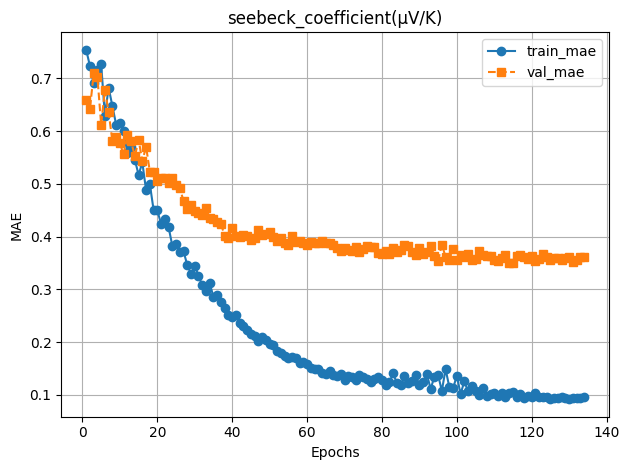


▶ Training for property: electrical_conductivity(S/m)
Epoch: 1/300 --- Train MAE: 4.3603  Val MAE: 3.9553
Epoch: 10/300 --- Train MAE: 1.0070  Val MAE: 1.4101
Epoch: 20/300 --- Train MAE: 0.8552  Val MAE: 0.8769
Epoch: 30/300 --- Train MAE: 0.8415  Val MAE: 0.8110
Epoch: 40/300 --- Train MAE: 0.8365  Val MAE: 0.7841
Epoch: 50/300 --- Train MAE: 0.7828  Val MAE: 0.7556
Epoch: 60/300 --- Train MAE: 0.7111  Val MAE: 0.7324
Epoch: 70/300 --- Train MAE: 0.6528  Val MAE: 0.7051
Epoch: 80/300 --- Train MAE: 0.5484  Val MAE: 0.6472
Epoch: 90/300 --- Train MAE: 0.4429  Val MAE: 0.5912
Epoch: 100/300 --- Train MAE: 0.3641  Val MAE: 0.5502
Epoch: 110/300 --- Train MAE: 0.3060  Val MAE: 0.5314
Epoch: 120/300 --- Train MAE: 0.2705  Val MAE: 0.5113
Epoch: 130/300 --- Train MAE: 0.2436  Val MAE: 0.5027
Epoch: 140/300 --- Train MAE: 0.2235  Val MAE: 0.5038
Epoch: 150/300 --- Train MAE: 0.2108  Val MAE: 0.4948
Epoch: 160/300 --- Train MAE: 0.2045  Val MAE: 0.4972
Epoch: 170/300 --- Train MAE: 0.2121  

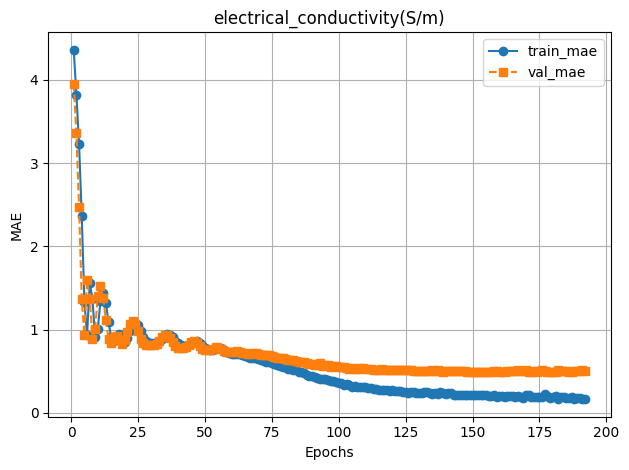


▶ Training for property: thermal_conductivity(W/mK)
Epoch: 1/300 --- Train MAE: 0.5615  Val MAE: 0.5405
Epoch: 10/300 --- Train MAE: 0.3653  Val MAE: 0.4430
Epoch: 20/300 --- Train MAE: 0.2777  Val MAE: 0.4136
Epoch: 30/300 --- Train MAE: 0.2014  Val MAE: 0.4113
Epoch: 40/300 --- Train MAE: 0.1763  Val MAE: 0.3750
Epoch: 50/300 --- Train MAE: 0.1371  Val MAE: 0.3661
Epoch: 60/300 --- Train MAE: 0.1201  Val MAE: 0.3363
Epoch: 70/300 --- Train MAE: 0.1126  Val MAE: 0.3277
Epoch: 80/300 --- Train MAE: 0.0951  Val MAE: 0.3286
Epoch: 90/300 --- Train MAE: 0.0890  Val MAE: 0.3247
Epoch: 100/300 --- Train MAE: 0.1025  Val MAE: 0.3295
Epoch: 110/300 --- Train MAE: 0.0827  Val MAE: 0.3252
Epoch: 120/300 --- Train MAE: 0.0806  Val MAE: 0.3184
Epoch: 130/300 --- Train MAE: 0.0721  Val MAE: 0.3024
Epoch: 140/300 --- Train MAE: 0.0609  Val MAE: 0.3040
Epoch: 150/300 --- Train MAE: 0.0613  Val MAE: 0.3113
Epoch: 160/300 --- Train MAE: 0.0596  Val MAE: 0.3067
Epoch: 170/300 --- Train MAE: 0.0617  Va

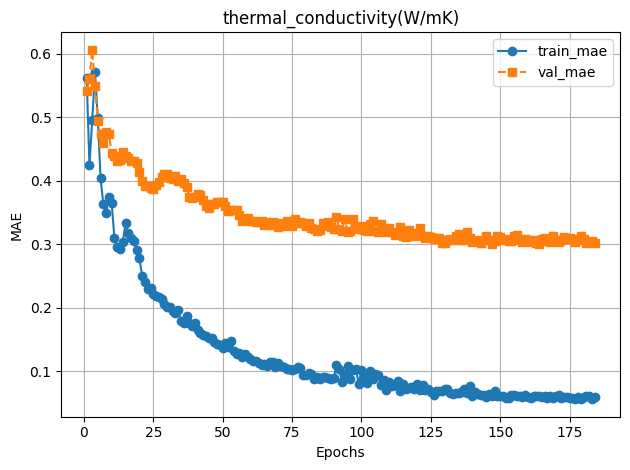

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from crabnet.kingcrab import CrabNet
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import copy

# 🔧 FormulaDataset 클래스는 미리 정의되어 있어야 함
# 🔧 fit 함수는 개선된 버전으로 정의되어 있어야 함 (return dict with 'train_mae', 'val_mae', etc.)

def fit(model, train_set, test_set, epochs=300, lr=1e-4, patience=20):
    device = model.compute_device
    model.to(device)
    model.train()

# 🟢 데이터 준비 (스택)
    src_train = torch.stack([s for s, _, _ in train_set]).to(device)
    frac_train = torch.stack([f for _, f, _ in train_set]).to(device)
    y_train = torch.stack([y for _, _, y in train_set]).float().to(device)

    src_test = torch.stack([s for s, _, _ in test_set]).to(device)
    frac_test = torch.stack([f for _, f, _ in test_set]).to(device)
    y_test = torch.stack([y for _, _, y in test_set]).float().to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_mae_list = []
    val_mae_list = []
    loss_list = []

    best_val_mae = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        model.train()

# 🟢 모델 예측
        output = model(src_train, frac_train)
        if isinstance(output, tuple):
            output = output[0]
        if output.ndim > 1 and output.shape[1] >= 2:
            output, _ = output.chunk(2, dim=1)
        y_pred = output.squeeze(-1) if output.ndim > 1 else output

# 🟢 손실 계산 및 역전파
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

# 🟢 검증 단계
        model.eval()
        with torch.no_grad():
            val_out = model(src_test, frac_test)
            if isinstance(val_out, tuple):
                val_out = val_out[0]
            if val_out.ndim > 1 and val_out.shape[1] >= 2:
                val_out, _ = val_out.chunk(2, dim=1)
            y_val = val_out.squeeze(-1) if val_out.ndim > 1 else val_out

# 🟢 MAE 기록
        train_mae = torch.mean(torch.abs(y_pred - y_train)).detach().item()
        val_mae = torch.mean(torch.abs(y_val - y_test)).detach().item()

        train_mae_list.append(train_mae)
        val_mae_list.append(val_mae)
        loss_list.append(loss.detach().item())

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch}/{epochs} --- Train MAE: {train_mae:.4f}  Val MAE: {val_mae:.4f}")

# 🟢 Early Stopping 로직
        if val_mae < best_val_mae - 1e-4:
            best_val_mae = val_mae
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch}")
            break

# 🟢 최적 모델 복원
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return {
        "train_mae": train_mae_list,
        "val_mae": val_mae_list,
        "loss": loss_list,
        "best_val_mae": best_val_mae
    }


# 🔷 학습 루프 (속성별 학습, 시각화, 저장)
models = {}

for prop in df1.columns[2:5]:  # 예: 'seebeck_coefficient(μV/K)', 'electrical_conductivity(S/m)', 'thermal_conductivity(W/mK)'
    print(f"\n▶ Training for property: {prop}")

    # 1. 모델 초기화
    cb = CrabNet(
        out_dims=2,
        d_model=512,
        heads=4,
        compute_device=torch.device("cpu"),
        residual_nn="roost"
    )

    # 2. 데이터 준비
    train_df = pd.DataFrame({
        'formula': df_train['Formula'],
        'target': df_train[prop]
    })
    test_df = pd.DataFrame({
        'formula': df_test['Formula'],
        'target': df_test[prop]
    })

    # 3. FormulaDataset 구성
    train_set = [sample for sample in FormulaDataset(train_df, formula_col='formula', target_col='target')]
    test_set = [sample for sample in FormulaDataset(test_df, formula_col='formula', target_col='target')]

    # 4. 학습
    result = fit(cb, train_set, test_set, epochs=300, lr=1e-4, patience=20)
    train_mae = result["train_mae"]
    val_mae = result["val_mae"]

    # 5. 시각화
    plt.figure()
    plt.plot(range(1, len(train_mae)+1), train_mae, label='train_mae', marker='o')
    plt.plot(range(1, len(val_mae)+1), val_mae, label='val_mae', marker='s', linestyle='--')
    plt.title(prop)
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6. 모델 저장
    models[prop] = cb
    torch.save(cb.state_dict(), f"crabnet_{prop.replace('/', '_')}.pt")


### Prediction ###

In [ ]:
from tqdm import tqdm

def predict(model, df, max_len=5):
    model.eval()
    device = model.compute_device

    src_list, frac_list = [], []
    for formula in df['formula']:
        elem_tensor, frac_tensor = formula_to_tensor(formula, max_len=max_len)
        src_list.append(elem_tensor)
        frac_list.append(frac_tensor)

    src = torch.stack(src_list).to(device)
    frac = torch.stack(frac_list).to(device)

    with torch.no_grad():
        output = model(src, frac)
        if isinstance(output, tuple):
            output = output[0]
        if output.shape[1] >= 2:
            output, _ = output.chunk(2, dim=1)
        pred = output.squeeze(-1).cpu().numpy()

    return pred


In [ ]:
# formula → (element index tensor, fraction tensor) 변환 함수
def formula_to_tensor(formula, max_len=5):
    comp = Composition(formula).fractional_composition
    elements = list(comp.keys())
    fractions = list(comp.values())

    elem_tensor = torch.zeros(max_len, dtype=torch.long)
    frac_tensor = torch.zeros(max_len, dtype=torch.float)

    for i, el in enumerate(elements[:max_len]):
        elem_tensor[i] = element_to_idx[str(el)]
        frac_tensor[i] = float(fractions[i])

    return elem_tensor, frac_tensor

In [ ]:
# 원소 인덱스 매핑
element_list = [
    "H",  "He", "Li", "Be", "B",  "C",  "N",  "O",  "F",  "Ne",
    "Na", "Mg", "Al", "Si", "P",  "S",  "Cl", "Ar", "K",  "Ca",
    "Sc", "Ti", "V",  "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y",  "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I",  "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W",  "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U",  "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

element_to_idx = {el: i + 1 for i, el in enumerate(element_list)}  # 0 reserved for padding

In [ ]:
train_pred, test_pred = {}, {}

for prop in df1.columns[2:5]:
    model = models[prop]

    # 예측
    train_df = pd.DataFrame({
        'formula': df_train['Formula'],
        'target': df_train[prop]
    })
    test_df = pd.DataFrame({
        'formula': df_test['Formula'],
        'target': df_test[prop]
    })

    train_pred[prop] = predict(model, train_df)
    test_pred[prop] = predict(model, test_df)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

def plot_pred_vs_true(
    df_train, df_test,
    train_pred, test_pred,
    train_sigma=None, test_sigma=None,
    props=None,
    figsize=(18, 5)
):
    """
    df_train/test: DataFrame containing 'Formula' and target props
    train_pred/test_pred: dict of prediction arrays
    train_sigma/test_sigma: optional dict of uncertainty arrays
    props: list of property names (columns in df)
    """
    fig, ax = plt.subplots(ncols=len(props), figsize=figsize)

    if len(props) == 1:
        ax = [ax]  # ensure iterable if one plot

    for i, prop in enumerate(props):
        # True values
        y_train_true = df_train[prop].to_numpy().ravel()
        y_test_true = df_test[prop].to_numpy().ravel()
        # Predicted values
        y_train_pred = train_pred[prop].ravel()
        y_test_pred = test_pred[prop].ravel()
        # Optional uncertainty
        y_train_sigma = train_sigma[prop].ravel() if train_sigma else None
        y_test_sigma = test_sigma[prop].ravel() if test_sigma else None

        # Metrics
        r2_train = r2_score(y_train_true, y_train_pred)
        mae_train = mean_absolute_error(y_train_true, y_train_pred)
        r2_test = r2_score(y_test_true, y_test_pred)
        mae_test = mean_absolute_error(y_test_true, y_test_pred)

        # Plot: y = x line
        min_val = min(y_train_true.min(), y_test_true.min(), y_train_pred.min(), y_test_pred.min())
        max_val = max(y_train_true.max(), y_test_true.max(), y_train_pred.max(), y_test_pred.max())
        ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

        # Train points
        ax[i].scatter(y_train_true, y_train_pred, label=f'Train R2: {r2_train:.2f}, MAE: {mae_train:.2f}', c='b')
        if y_train_sigma is not None:
            ax[i].errorbar(y_train_true, y_train_pred, yerr=y_train_sigma, ls='none', c='b', alpha=0.3)

        # Test points
        ax[i].scatter(y_test_true, y_test_pred, label=f'Test R2: {r2_test:.2f}, MAE: {mae_test:.2f}', c='r')
        if y_test_sigma is not None:
            ax[i].errorbar(y_test_true, y_test_pred, yerr=y_test_sigma, ls='none', c='r', alpha=0.3)

        ax[i].set_title(prop)
        ax[i].set_xlabel("True")
        ax[i].set_ylabel("Predicted")
        ax[i].legend()

    plt.tight_layout()
    plt.show()

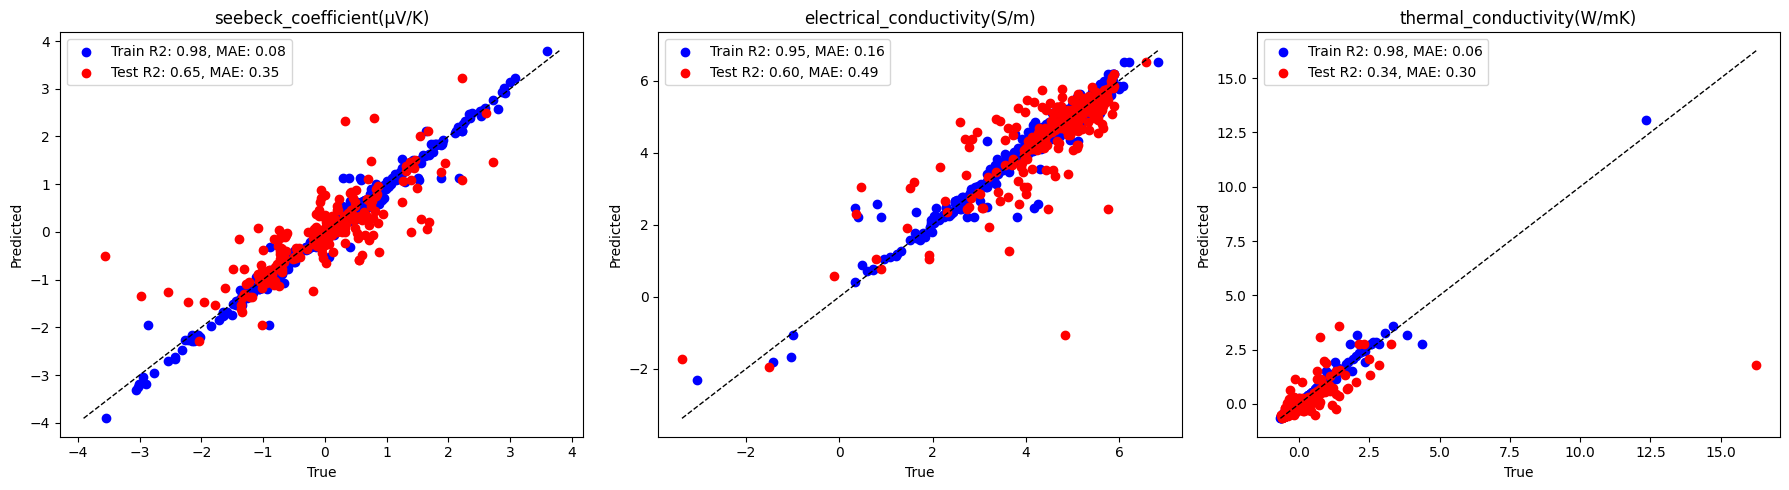

In [ ]:
plot_pred_vs_true(
    df_train=df_train,
    df_test=df_test,
    train_pred=train_pred,
    test_pred=test_pred,
    props=df1.columns[2:5].tolist()  # sigma 생략
)
